# Developmental plasticity of IBAPs
Here, we will investigate whether individual brain aberration patterns (IBAPs) of prematurity are plastic to the early social environment. To this end, we will perform the following analyses:
1. Conduct a PCA to identify a main axis of variation (PC1) in IBAPs of preterm adults.
2. Investigate the impact of early social environment on adult IBAPs. Therefore, we will test the association between PC1 variables of the early social environment in preterm adults and test whether socio-economic status (SES) moderates the relationship between PC1 and gestational age.
For the moderation analysis of the effect of SES on the relationship between PC1 and gestational age, the [PROCESS toolbox](http://processmacro.org/download.html#/) is required. Please refer to the Installation requirements for further details. Adapt `process_sw_dir` to the directory where the toolbox is located on your system.


In [28]:
# manually set path to R if there are problems with the automatic detection
# import os
# os.environ['R_HOME'] = '/Library/Frameworks/R.framework/R'  # adapt to your R installation

In [29]:
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [30]:
import os
from os.path import join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plot settings
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

from statsmodels.formula.api import ols
from scipy.stats import spearmanr

# import custom functions
import sys
sys.path.append('code')
from plotting import correlation_plot, plot_pc_loadings
from utils import read_process_output, get_roi_names
from stats import conduct_pca

# directories
centile_dir = join('outputs', 'spatial_heterogeneity')
outputs_dir_main = join('outputs', 'developmental_plasticity_IQ')
os.makedirs(outputs_dir_main, exist_ok=True)

process_sw_dir = join('code', 'processv43', 'PROCESS v4.3 for R')  # adapt to your installation

color_pt = 'darkorange'

# some settings - please adapt to your needs
dataset = 'BLS-26'  # dHCP, ABCD-10, BLS-26

outputs_dir = join(outputs_dir_main, dataset)
os.makedirs(outputs_dir, exist_ok=True)

In [31]:
# load all necessary data, i.e., deviation scores computed in script 1
try:
    ct = pd.read_csv(join(centile_dir, f'{dataset}/IBAP_CT/{dataset}_CT_centiles_per_subject.csv'), index_col=0)
    sa = pd.read_csv(join(centile_dir, f'{dataset}/IBAP_SA/{dataset}_SA_centiles_per_subject.csv'), index_col=0)
except FileNotFoundError:
    print(f'Run script 1 for all required modalities and datasets first: {dataset}')
    sys.exit()

In [32]:
# definition of variable names
dataset_vars = {
    "dHCP": {
        "cognition_var": "bsid_cog_composite",
        "cognition_label": "Bayley-III cognitive composite score [a.u.]",
        "ses_var": "SES_parent_education",
        "ses_label": "Mean age of last continuous full-time education [years]",
    },
    "ABCD-10": {
        "cognition_var": "nihtbx_total",
        "cognition_label": "NIH cognition total composite score [a.u.]",
        "ses_var": "SES_parent_education",
        "ses_label": "Parental education [a.u.]",
    },
        "BLS-26": {
        "cognition_var": "IQ",
        "cognition_label": "Full-scale IQ [a.u.]",
        "ses_var": "SES_at_birth",
        "ses_label": "Socioeconomic status [a.u.]",
    }
}

meta = dataset_vars[dataset]
cognition_var = meta["cognition_var"]
cognition_label = meta["cognition_label"]
ses_var = meta["ses_var"]
ses_label = meta["ses_label"]

# 1. PCA across regions

In [33]:
print(f'--- PCA for {dataset} ---')
pc_ct, ct_loadings = conduct_pca(ct, brain_measure='CT')
pc_sa, sa_loadings = conduct_pca(sa, brain_measure='SA')

# add PC1 of SA and CT column
ct['PC1_CT'] = pc_ct[:, 0]
sa['PC1_SA'] = pc_sa[:, 0]

# save PC loadings
ct_loadings.to_csv(join(outputs_dir, 'PCA_loadings_CT.csv'))
sa_loadings.to_csv(join(outputs_dir, 'PCA_loadings_SA.csv'))


--- PCA for BLS-26 ---
Conducting PCA on CT deviation scores...
Explained variance per principal component: 37.49%, 5.96% and 5.61%
Conducting PCA on SA deviation scores...
Explained variance per principal component: 40.05%, 7.40% and 4.53%


### PC1 loadings

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:315: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:317: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


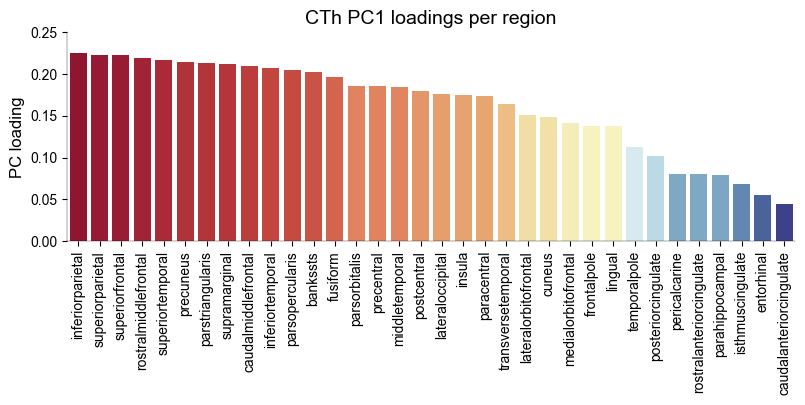

In [34]:
# CTh
loadings_ordered = pd.DataFrame(ct_loadings.sort_values(ascending=False))
loadings_ordered['order'] = np.arange(1,35,1)
loadings_ordered.index.name = 'ROI'
loadings_ordered.reset_index(inplace=True)

plot_pc_loadings(loadings_ordered, outputs_dir, brain_measure_name='CTh')

/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:315: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xticklabels, rotation=90, fontsize=10)
/Users/melissa/Dokumente/PhD/01B_preterm_normative/scripts/preterm-brain-heterogeneity/code/plotting.py:317: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)


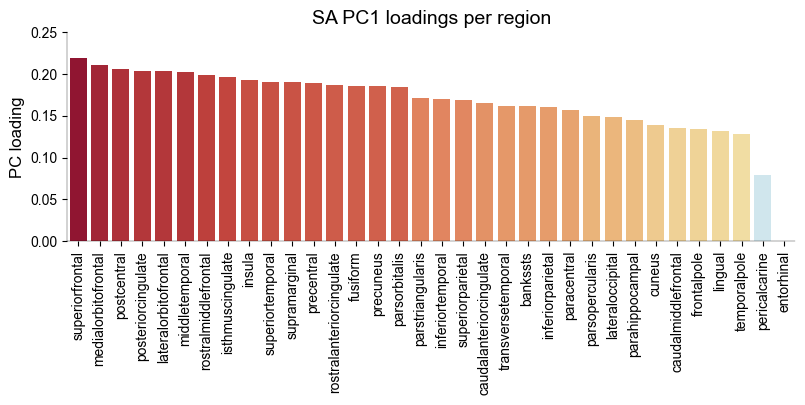

In [35]:
# SA
loadings_ordered = pd.DataFrame(sa_loadings.sort_values(ascending=False))
loadings_ordered.loc['centile_SA_entorhinal', 'PC1_loadings'] = 0  # set entorhinal to 0
loadings_ordered['order'] = np.arange(1,35,1)
loadings_ordered.index.name = 'ROI'
loadings_ordered.reset_index(inplace=True)

plot_pc_loadings(loadings_ordered, outputs_dir, brain_measure_name='SA')

# 2. Impact of early social environment on IBAPs
### Correlation between early social environment and IBAPs

In [36]:
out_dir = join(outputs_dir, 'social_env')
os.makedirs(out_dir, exist_ok=True)

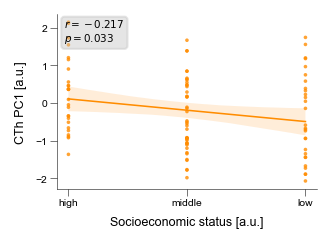

In [37]:
# socio-economic status at birth (SES)
x = ses_var
y = 'PC1_CT'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = ct[ct['dx'] == 'preterm']

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=ses_label, ylabel='CTh PC1 [a.u.]', outname=outname)

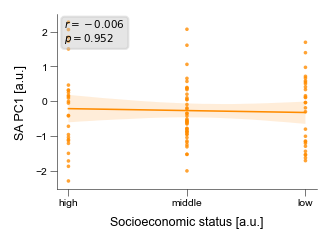

In [38]:
# socio-economic status at birth (SES)
x = ses_var
y = 'PC1_SA'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

# filter for preterms
sa_pt = sa[sa['dx'] == 'preterm']

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                xlabel=ses_label, ylabel='SA PC1 [a.u.]', outname=outname)

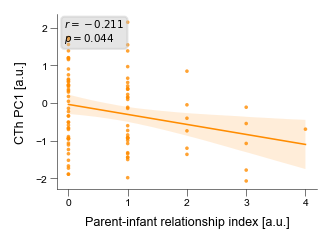

In [39]:
# parent-infant relationship index (PIRI)
if dataset == 'BLS-26':
    x = 'PIRI'
    y = 'PC1_CT'
    outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

    dat_piri = ct_pt[[x,y]].dropna()
    dat_piri = dat_piri[dat_piri[x] < 9] # since 9 means missing data

    correlation_plot(x, y, data=dat_piri, color=color_pt, 
                    xlabel='Parent-infant relationship index [a.u.]', ylabel='CTh PC1 [a.u.]', outname=outname)

### Moderation of SES on association between GA and PC1_CT

In [40]:
# direct effect of GA on PC1 while controlling for interaction
r, p = spearmanr(ct_pt['GA'], ct_pt['PC1_CT'])
print(f'Spearman correlation between GA and PC1_CT: r={r:.3f} and p={p:.3f}')

print('Direct effect in moderation model:')
ols(f'GA ~ PC1_CT + (GA * {ses_var})', data=ct_pt).fit().summary()  # one-sided p-value was used in the paper

Spearman correlation between GA and PC1_CT: r=0.264 and p=0.009
Direct effect in moderation model:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     GA   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.113e+28
Date:                Fri, 06 Jun 2025   Prob (F-statistic):               0.00
Time:                        11:01:07   Log-Likelihood:                 2771.1
No. Observations:                  96   AIC:                            -5532.
Df Residuals:                      91   BIC:                            -5519.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.842e-14    2.9e-13     -0.098      0.922   -6.05e-13    5.48e-13
PC1_CT           1.332e-15   7.88e-15      0.169      0.866   -1.43e-14     1.7e-14
GA                  1.0000   9.46e-15   1.06e+14      0.000       1.000       1.000
SES_at_birth     1.421e-14   1.35e-13      0.105      0.916   -2.54e-13    2.83e-13
GA:SES_at_birth  -1.11e-15   4.37e-15     -0.254      0.800   -9.79e-15    7.57e-15
==============================================================================
Omnibus:                        5.651   Durbin-Watson:                   0.123
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                3.408
Skew:                           0.270   Prob(JB):                        0.182
Kurtosis:                       2.251   Cond. No.                     3.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# save current dir for later use
cwd = os.getcwd()

In [42]:
%%R -i ct_pt -i process_sw_dir -i out_dir -i cwd -i dataset -i ses_var

setwd(process_sw_dir)
source('process.R')
setwd(cwd)

# run moderation analysis: GA -> SES -> PC1
outname = paste0(dataset, '_CT_moderation_GA_SES.txt')
output_file <- file.path(out_dir, outname)
sink(output_file)
process(data = ct_pt, 
        y="PC1_CT", 
        x="GA", 
        w=ses_var,
        model=1, 
        boot = 5000,
        conf = 95,
        center = FALSE,
        plot = 1,
        save=1,
        seed=1234)

sink()



********************* PROCESS for R Version 4.3.1 ********************* 
 
           Written by Andrew F. Hayes, Ph.D.  www.afhayes.com              
   Documentation available in Hayes (2022). www.guilford.com/p/hayes3   
 
*********************************************************************** 
 
PROCESS is now ready for use.
Copyright 2020-2023 by Andrew F. Hayes ALL RIGHTS RESERVED
Workshop schedule at http://haskayne.ucalgary.ca/CCRAM
 


In [43]:
# load data from process moderation analysis in R
mod_orig_path = os.path.join(out_dir, f'{dataset}_CT_moderation_GA_SES.txt')
mod = read_process_output(mod_orig_path)
display(mod)

,GA,SES_at_birth,PC1_CT
0,29.00,1.0,0.0946
1,30.00,1.0,0.1335
2,32.48,1.0,0.2300
3,29.00,2.0,-0.4149
4,30.00,2.0,-0.2723
5,32.48,2.0,0.0814
6,29.00,3.0,-0.9245
7,30.00,3.0,-0.6781
8,32.48,3.0,-0.0671


In [44]:
# restore plotting settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

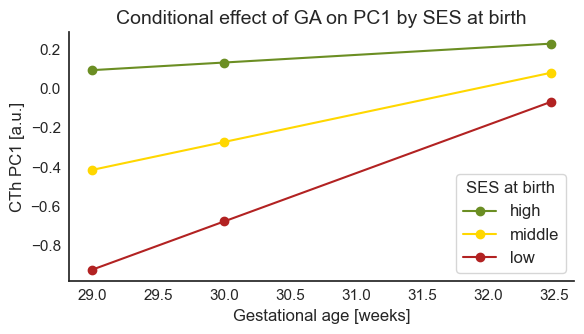

In [45]:
## plot moderation effect
if dataset == 'BLS-26':
    
    # label and plot settings
    ses_labels = {
        1: 'high',
        2: 'middle',
        3: 'low'
    }
    mod['SES_label'] = mod['SES_at_birth'].map(ses_labels)
    sns.set(style="white")
    colors = {
        'low': 'firebrick',
        'middle': 'gold',
        'high': 'olivedrab'
    }

    # plot interaction effect
    plt.figure(figsize=(6,3.5))

    for SES in mod['SES_label'].unique():
        subset = mod[mod['SES_label'] == SES]
        plt.plot(subset['GA'], subset['PC1_CT'], marker='o',label=f'{SES}', color=colors[SES])

    plt.xlabel('Gestational age [weeks]',  fontsize=12)
    plt.ylabel('CTh PC1 [a.u.]', fontsize=12)
    plt.tick_params(axis='both', which='major', width=0.25, pad=0)
    plt.title('Conditional effect of GA on PC1 by SES at birth', fontsize=14)
    plt.legend(title='SES at birth', fontsize=12, title_fontsize=12)


    sns.despine()
    plt.tight_layout()
    plt.savefig(join(out_dir, f'{dataset}_CT_moderation_SES.svg'), dpi=300)

    plt.show()


### Supplementary analysis

In [46]:
# restore plotting settings
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc_file('code/matplotlibrc')

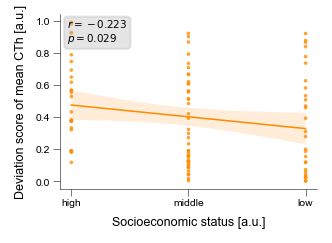

In [47]:
# deviation score of mean CTh
x = ses_var
y = 'centile_meanCT2'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = ct[ct['dx'] == 'preterm']

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=ses_label, ylabel='Deviation score of mean CTh [a.u.]', outname=outname)

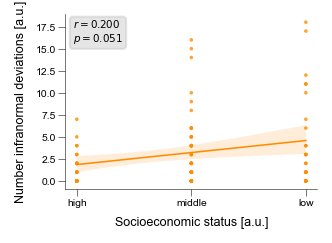

In [48]:
# Number of infranormal deviations
x = ses_var
y = 'amount_infranormal'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
bls_26_ct_pt = ct[ct['dx'] == 'preterm']

correlation_plot(x, y, data=bls_26_ct_pt, color=color_pt, 
                xlabel=ses_label, ylabel='Number infranormal deviations [a.u.]', outname=outname)

# 3. Impacts on cognitive outcome variability

In [49]:
out_dir = join(outputs_dir, 'cognition')
os.makedirs(out_dir, exist_ok=True)

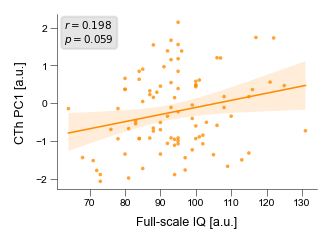

In [50]:
# PC1 of CTh
x = cognition_var
y = 'PC1_CT'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

# filter for preterms
ct_pt = ct[ct['dx'] == 'preterm']

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='CTh PC1 [a.u.]', outname=outname)

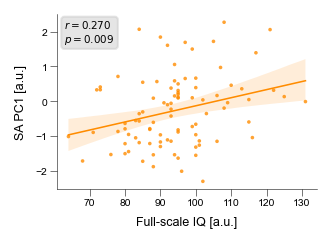

In [51]:
# PC1 of SA
x = cognition_var
y = 'PC1_SA'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

# filter for preterms
sa_pt = sa[sa['dx'] == 'preterm']

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='SA PC1 [a.u.]', outname=outname)

### Supplementary analysis

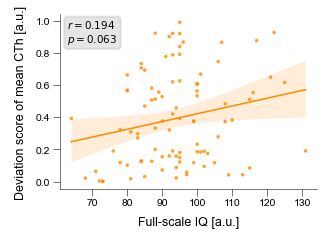

In [52]:
# deviation score of mean CTh
x = cognition_var
y = 'centile_meanCT2'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='Deviation score of mean CTh [a.u.]', outname=outname)

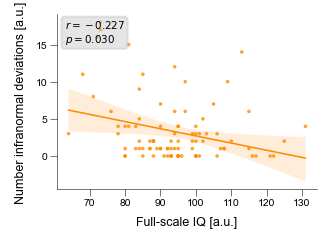

In [53]:
# number of infranormal regions CTh
x = cognition_var
y = 'amount_infranormal'
outname = join(out_dir, f'{dataset}_CT_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=ct_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='Number infranormal deviations [a.u.]', outname=outname)

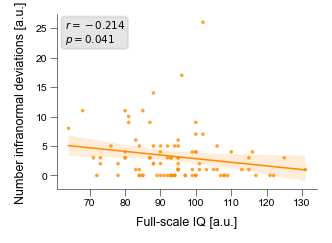

In [54]:
# number of infranormal regions SA
x = cognition_var
y = 'amount_infranormal'
outname = join(out_dir, f'{dataset}_SA_preterm_correlation_{x}_{y}.svg')

correlation_plot(x, y, data=sa_pt, color=color_pt, 
                xlabel=cognition_label, ylabel='Number infranormal deviations [a.u.]', outname=outname)